# Table of Contents
* [Libaries](#Libaries)
* [Working on LAC vs GSW](#Working-on-LAC-vs-GSW)
	* [Collect P Values for Multiple Variables](#Collect-P-Values-for-Multiple-Variables)
		* [Sort Topouts DataFrame](#Sort-Topouts-DataFrame)
		* [Add English Variable Names](#Add-English-Variable-Names)
* [Make Mega Plots](#Make-Mega-Plots)
	* &nbsp;
		* [Draft Plot Format](#Draft-Plot-Format)
		* [Choose Subset to Plot](#Choose-Subset-to-Plot)
		* [Game File Search](#Game-File-Search)
		* [Correlation Plot Example](#Correlation-Plot-Example)
* [Recent Game Analysis](#Recent-Game-Analysis)
* [PCA](#PCA)
* [Detritus](#Detritus)
* [Functions](#Functions)


# Libaries

In [1]:
import pandas as pd
import cPickle as pickle
%pylab inline
import seaborn as sns
import sys
import statsmodels.formula.api as smf

sys.path.append('./hoopla')


from hoopla import hoopla as hp

Populating the interactive namespace from numpy and matplotlib


In [ ]:
reload(hp) # As needed

# Working on LAC vs GSW

In [2]:
#df = pd.read_pickle("data/fullstats_lac_gsw_20142015_103115_v3.p") # GSW 11/5/14 to 3/8/15
#df = pd.read_pickle("data/fullstats_lac_dal_20132016_110415_v1.p") # GSW 1/30/14 to 3/8/15
#df = pd.read_pickle("data/fullstats_lac_dal_20132016_110515_v1.p") # DAL
#df = pd.read_pickle("data/fullstats_lac_dal_20132016_110215_v5.p") # DAL
#df = pd.read_pickle("data/fullstats_lac_gsw_20132016_110415_v6.p")
df = pd.read_pickle("data/fullstats_lac_gsw_20132016_11112015_185155.p")
df['OpponentTeamID'][0]
# GSW are 1610612744
df.tail()

TEAM_ID             TEAM_NAME  GP  W  L  W_PCT  MIN  FGM  FGA  \
PeriodID                                                                        
3-31-2015_4  1610612746  Los Angeles Clippers   1  0  1      0   12    3   13   
11-4-2015_1  1610612746  Los Angeles Clippers   1  0  1      0   12   10   22   
11-4-2015_2  1610612746  Los Angeles Clippers   1  0  1      0   12   11   20   
11-4-2015_3  1610612746  Los Angeles Clippers   1  0  1      0   12   12   20   
11-4-2015_4  1610612746  Los Angeles Clippers   1  0  1      0   12   10   26   

             FG_PCT    ...     OPP_FT_PCT  OPP_STL  OPP_FG3A  OPP_PTS  \
PeriodID               ...                                              
3-31-2015_4   0.231    ...          0.867        3         3       28   
11-4-2015_1   0.455    ...          1.000        0         6       31   
11-4-2015_2   0.550    ...          0.727        1         7       32   
11-4-2015_3   0.600    ...          0.833        3         6       19   
11-4-2015_4   0.385    ...          0.625        0         7       30   

             OPP_AST  OPP_FGA  OPP_OREB  OPP_DREB  OPP_FTM  OPP_FG3M  
PeriodID                                                              
3-31-2015_4        6       17         2         7       13         1  
11-4-2015_1        9       27         3         9        6         1  
11-4-2015_2        7       21         3         8        8         4  
11-4-2015_3        5       21         2         6        5         0  
11-4-2015_4        7       16         1        10        5         5  

[5 rows x 99 columns]

## Collect P Values for Multiple Variables

In [3]:
# Collect all columns as unicode vars
all_vars = []
for x in df.columns.tolist():
    all_vars.append(x.encode())

    
#vars_of_interest = ["DREB","PCT_PTS_3PT","OPP_FG3M","OPP_FG3_PCT","STL"]


vars_of_interest = all_vars
#vars_of_interest = ["REB_PCT","EFG_PCT","PTS_OFF_TOV"]

target = "PLUS_MINUS"


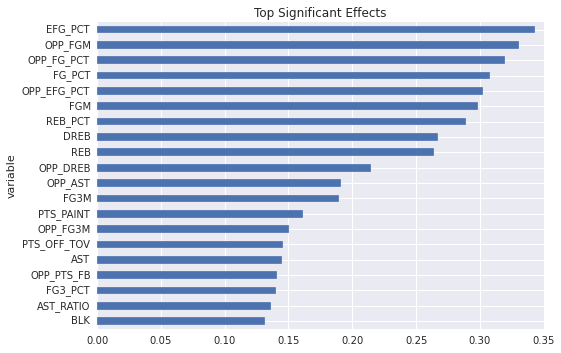

In [7]:
# Make model frame
pvals = get_model_var(vars_of_interest,target,df,"pvalue")
rsqrs = get_model_var(vars_of_interest,target,df,"rsquared")
coefs = get_model_var(vars_of_interest,target,df,"coef")

outputs = pvals.join(rsqrs)
outputs = outputs.join(coefs)

overall_outputs = outputs

#outputs = outputs.loc[pct_vars]


# ignore obvious correlated vars of not interest


ignorevars = ["PLUS_MINUS","NET_RATING","PIE","OPP_PTS","DEF_RATING","OFF_RATING","PTS","W","L","W_PCT","TS_PCT","OPP_BLKA"]

new_index = []

for n in outputs.index.tolist():
    if n not in ignorevars:
        new_index.append(n)

    
    
outputs = outputs.loc[new_index]

# limit to significant
topouts = outputs[outputs.pvalue < .05].sort("rsquared").tail(30)

# ignore significance
# topouts = outputs.sort("rsquared").tail(20)



topouts.rsquared.plot(kind='barh')
plt.title('Top Significant Effects')

In [8]:
### Sort Topouts DataFrame

topouts = topouts.sort("rsquared",ascending=False)

### Add English Variable Names

enames = pd.read_csv("data/reference/english_varnames.csv",index_col=0,names=['variable','english_varnames'])

# add in names to topouts
topouts = topouts.join(enames)

# Make Mega Plots

### Draft Plot Format

In [9]:
timestamp = hp.timestamp()
filename = "data/topouts_lac_gsw_" + timestamp + ".p"
topouts.to_pickle(filename)

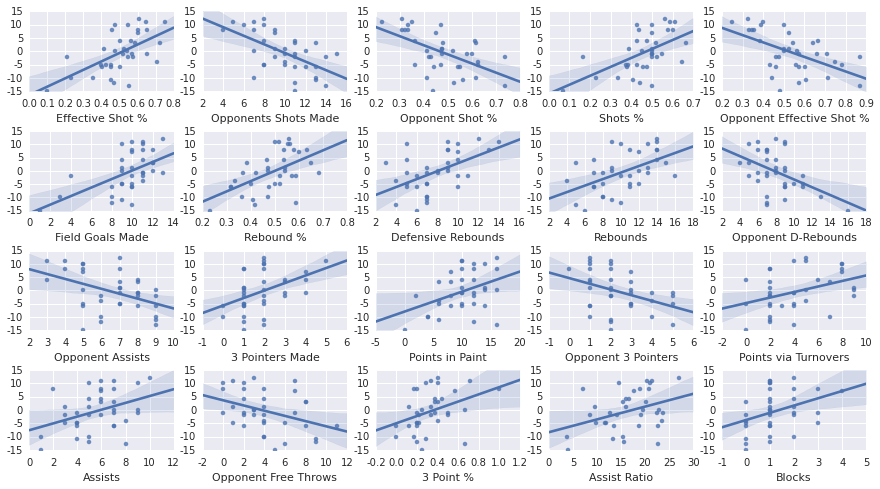

In [270]:
timestamp = hp.timestamp()
outfilename = "outputs/images/LAC_GSW_OUT_" + timestamp + ".svg"
rowcount = 5
colcount = 5
i = 1
plt.figure(figsize=(15,10))

#plt.suptitle('Top Effects per Quarter on Point Differentials:\n Clippers vs Warriors',fontsize=20,x=0)
#plt.suptitle('Top Effects per Quarter on Point Differentials:\n Clippers vs Warriors',fontsize=4,y=.5)

for v in topouts.index.tolist():
    # subplot(rows,columns)
    plt.subplot(rowcount,colcount,i)
    
    sns.regplot(x=v,y=target,data=df)
    plt.ylim(-15,15)
    plt.ylabel("")
    plt.xlabel(topouts.ix[v]['english_varnames'])
    i += 1

plt.savefig(outfilename)

In [264]:
topouts

pvalue  rsquared       coef           english_varnames
variable                                                             
EFG_PCT      0.000172  0.343675  31.673016           Effective Shot %
OPP_FGM      0.000246  0.330407  -1.621831       Opponents Shots Made
OPP_FG_PCT   0.000328  0.319535 -34.296720            Opponent Shot %
FG_PCT       0.000439  0.308337  33.626941                    Shots %
OPP_EFG_PCT  0.000505  0.302923 -27.364250  Opponent Effective Shot %
FGM          0.000567  0.298457   1.615894           Field Goals Made
REB_PCT      0.000716  0.289311  38.561342                  Rebound %
DREB         0.001244  0.267284   1.496172         Defensive Rebounds
REB          0.001340  0.264294   1.227761                   Rebounds
OPP_DREB     0.004410  0.214865  -1.460579        Opponent D-Rebounds
OPP_AST      0.007698  0.190983  -1.846939           Opponent Assists
FG3M         0.007892  0.189907   2.824235            3 Pointers Made
PTS_PAINT    0.015223  0.161195   0.753623            Points in Paint
OPP_FG3M     0.019366  0.150559  -2.133909        Opponent 3 Pointers
PTS_OFF_TOV  0.021760  0.145391   1.040868       Points via Turnovers
AST          0.022021  0.144862   1.284529                    Assists
OPP_PTS_FB   0.024147  0.140769  -0.980117       Opponent Free Throws
FG3_PCT      0.024335  0.140424  13.615284                  3 Point %
AST_RATIO    0.026629  0.136417   0.481817               Assist Ratio
BLK          0.029735  0.131503   2.733766                     Blocks
OPP_BLKA     0.029735  0.131503   2.733766           Opponents Blocks

### Choose Subset to Plot

In [271]:
Playvars = ["REB_PCT","EFG_PCT","PTS_OFF_TOV"]
#Playvars = ["DREB","EFG_PCT","OPP_PTS_OFF_TOV"]

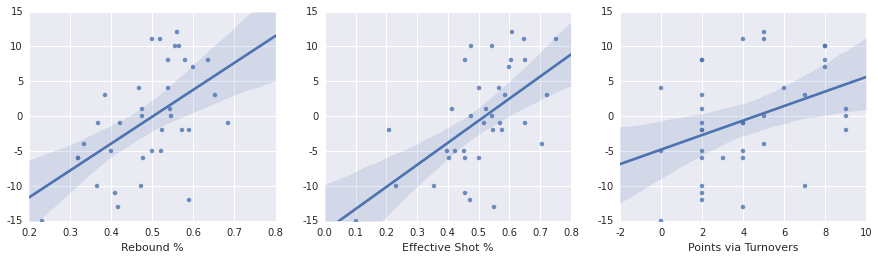

In [272]:
timestamp = hp.timestamp()
outfilename = "outputs/images/3graph_LAC_GSW_OUT_" + timestamp + ".svg"

rowcount = 3
colcount = 3
i = 1
plt.figure(figsize=(15,15))

#plt.suptitle('Top Effects per Quarter on Point Differentials:\n Clippers vs Warriors',fontsize=20,x=0)
#plt.suptitle('Top Effects per Quarter on Point Differentials:\n Clippers vs Warriors',fontsize=4,y=.5)

#for v in topouts.index.tolist()[2:]:
for v in Playvars:
    # subplot(rows,columns)
    plt.subplot(rowcount,colcount,i)
    
    sns.regplot(x=v,y=target,data=df)
    plt.ylim(-15,15)
    plt.ylabel("")
    plt.xlabel(topouts.ix[v]['english_varnames'])
    i += 1

plt.savefig(outfilename)

### Game File Search

For Latest Dates

In [275]:
len(df.DateFrom.unique())

9

### Correlation Plot Example

In [32]:
sns.corrplot?

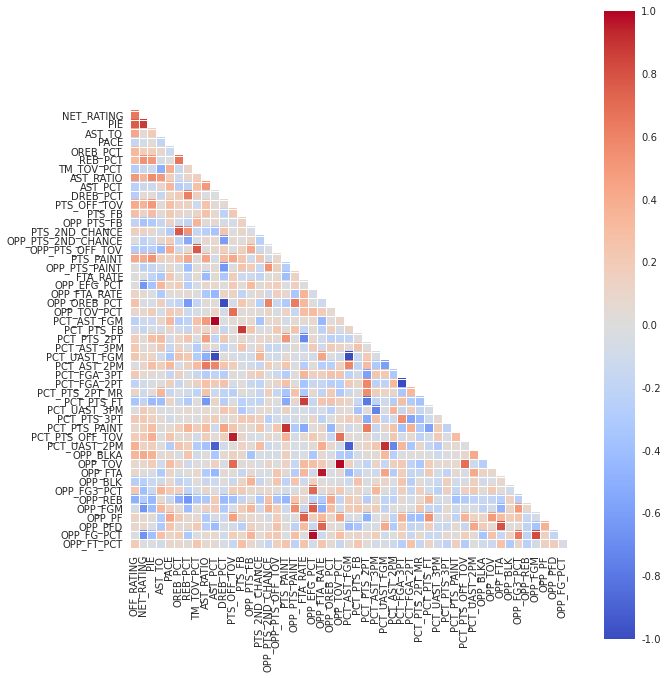

In [38]:
plt.figure(figsize=(10,15))
somevars = df.T[40:90].index.tolist()
sns.corrplot(df[somevars],annot=False,sig_stars=False,diag_names=False)

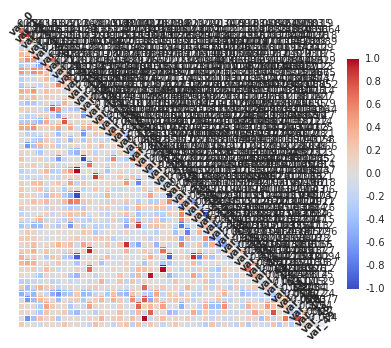

In [24]:
sns.corrplot(a.values)

# Recent Game Analysis

In [7]:
# Assuming df is full loaded df
dfr = df.tail(4) #isolate recent game

In [8]:
dfr

TEAM_ID             TEAM_NAME  GP  W  L  W_PCT  MIN  FGM  FGA  \
PeriodID                                                                        
11-4-2015_1  1610612746  Los Angeles Clippers   1  0  1      0   12   10   22   
11-4-2015_2  1610612746  Los Angeles Clippers   1  0  1      0   12   11   20   
11-4-2015_3  1610612746  Los Angeles Clippers   1  0  1      0   12   12   20   
11-4-2015_4  1610612746  Los Angeles Clippers   1  0  1      0   12   10   26   

             FG_PCT    ...     OPP_FT_PCT  OPP_STL  OPP_FG3A  OPP_PTS  \
PeriodID               ...                                              
11-4-2015_1   0.455    ...          1.000        0         6       31   
11-4-2015_2   0.550    ...          0.727        1         7       32   
11-4-2015_3   0.600    ...          0.833        3         6       19   
11-4-2015_4   0.385    ...          0.625        0         7       30   

             OPP_AST  OPP_FGA  OPP_OREB  OPP_DREB  OPP_FTM  OPP_FG3M  
PeriodID                                                              
11-4-2015_1        9       27         3         9        6         1  
11-4-2015_2        7       21         3         8        8         4  
11-4-2015_3        5       21         2         6        5         0  
11-4-2015_4        7       16         1        10        5         5  

[4 rows x 99 columns]

### Run Significant Frame Maker

In [ ]:
df = dfr

In [13]:
# Collect all columns as unicode vars
all_vars = []
for x in df.columns.tolist():
    all_vars.append(x.encode())

    
#vars_of_interest = ["DREB","PCT_PTS_3PT","OPP_FG3M","OPP_FG3_PCT","STL"]


vars_of_interest = all_vars
#vars_of_interest = ["REB_PCT","EFG_PCT","PTS_OFF_TOV"]

target = "PLUS_MINUS"


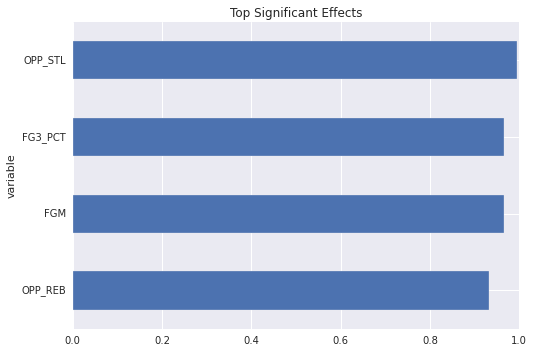

In [14]:

# Make model frame
pvals = get_model_var(vars_of_interest,target,df,"pvalue")
rsqrs = get_model_var(vars_of_interest,target,df,"rsquared")
coefs = get_model_var(vars_of_interest,target,df,"coef")

outputs = pvals.join(rsqrs)
outputs = outputs.join(coefs)

overall_outputs = outputs

#outputs = outputs.loc[pct_vars]


# ignore obvious correlated vars of not interest


ignorevars = ["PLUS_MINUS","NET_RATING","PIE","OPP_PTS","DEF_RATING","OFF_RATING","PTS","W","L","W_PCT","TS_PCT","OPP_BLKA"]

new_index = []

for n in outputs.index.tolist():
    if n not in ignorevars:
        new_index.append(n)

    
    
outputs = outputs.loc[new_index]

# limit to significant
topouts = outputs[outputs.pvalue < .05].sort("rsquared").tail(30)

# ignore significance
# topouts = outputs.sort("rsquared").tail(20)



topouts.rsquared.plot(kind='barh')
plt.title('Top Significant Effects')

In [16]:
### Sort Topouts DataFrame

topouts = topouts.sort("rsquared",ascending=False)

### Add English Variable Names

enames = pd.read_csv("data/reference/english_varnames.csv",index_col=0,names=['variable','english_varnames'])

# add in names to topouts
topouts = topouts.join(enames)

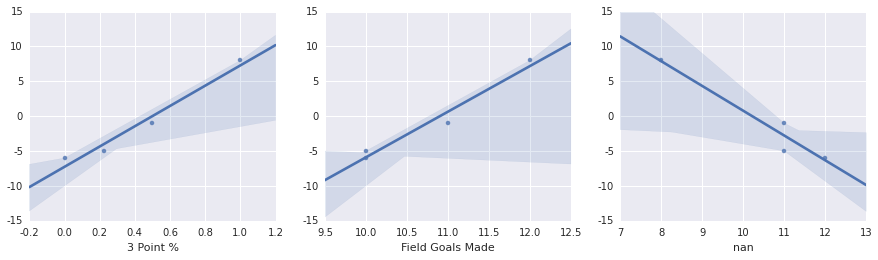

In [17]:
# REVAMP TRIPLE SHOW

Playvars = ["FG3_PCT","FGM","OPP_REB"]
timestamp = hp.timestamp()
outfilename = "outputs/images/3graph_LAC_GSW_OUT_" + timestamp + ".svg"

rowcount = 3
colcount = 3
i = 1
plt.figure(figsize=(15,15))

#plt.suptitle('Top Effects per Quarter on Point Differentials:\n Clippers vs Warriors',fontsize=20,x=0)
#plt.suptitle('Top Effects per Quarter on Point Differentials:\n Clippers vs Warriors',fontsize=4,y=.5)

#for v in topouts.index.tolist()[2:]:
for v in Playvars:
    # subplot(rows,columns)
    plt.subplot(rowcount,colcount,i)
    
    sns.regplot(x=v,y=target,data=df)
    plt.ylim(-15,15)
    plt.ylabel("")
    plt.xlabel(topouts.ix[v]['english_varnames'])
    i += 1

plt.savefig(outfilename)

In [174]:
df.columns

Index([           u'TEAM_ID',          u'TEAM_NAME',                 u'GP',
                        u'W',                  u'L',              u'W_PCT',
                      u'MIN',                u'FGM',                u'FGA',
                   u'FG_PCT',               u'FG3M',               u'FG3A',
                  u'FG3_PCT',                u'FTM',                u'FTA',
                   u'FT_PCT',               u'OREB',               u'DREB',
                      u'REB',                u'AST',                u'TOV',
                      u'STL',                u'BLK',               u'BLKA',
                       u'PF',                u'PFD',                u'PTS',
               u'PLUS_MINUS',               u'CFID',           u'CFPARAMS',
              u'MeasureType',     u'OpponentTeamID',             u'DateTo',
                 u'DateFrom',             u'Period',             u'TeamID',
                   u'TS_PCT',            u'EFG_PCT',         u'DEF_RATING',
            

OpponentTeamID      TeamID             TEAM_NAME     TEAM_ID
0      1610612744  1610612746  Los Angeles Clippers  1610612746
1      1610612744  1610612746  Los Angeles Clippers  1610612746
2      1610612744  1610612746  Los Angeles Clippers  1610612746
3      1610612744  1610612746  Los Angeles Clippers  1610612746
4      1610612744  1610612746  Los Angeles Clippers  1610612746
5      1610612744  1610612746  Los Angeles Clippers  1610612746
6      1610612744  1610612746  Los Angeles Clippers  1610612746
7      1610612744  1610612746  Los Angeles Clippers  1610612746
8      1610612744  1610612746  Los Angeles Clippers  1610612746
9      1610612744  1610612746  Los Angeles Clippers  1610612746
10     1610612744  1610612746  Los Angeles Clippers  1610612746
11     1610612744  1610612746  Los Angeles Clippers  1610612746
12     1610612744  1610612746  Los Angeles Clippers  1610612746
13     1610612744  1610612746  Los Angeles Clippers  1610612746
14     1610612744  1610612746  Los Angeles Clippers  1610612746
15     1610612744  1610612746  Los Angeles Clippers  1610612746

In [345]:
df[(df.REB_PCT > .55) & (df.NET_RATING > 20)][['REB_PCT','PLUS_MINUS']]
# Game date is 3/31/2015, quarter 1


# GAME ID BOX SCORE -- IF I CAN GET FROM DATE??
# http://stats.nba.com/game/#!/0021401111/
"""
Matt Barnes Grabbing Rebound
http://on.nba.com/1Q5Rhb0



"""

REB_PCT  PLUS_MINUS
PeriodID                         
10-31-2013_1    0.556          10
3-12-2014_3     0.600           7
3-12-2014_4     0.636           8
11-5-2014_4     0.565          10
3-31-2015_1     0.560          12

In [342]:
"""
video of all of their offensive rebounds:

http://on.nba.com/1Q5QXsS

and main link:
http://stats.nba.com/team/#!/1610612746/gamelogs/?Season=2013-14&SeasonType=Regular%20Season&CF=WL*E*W%7CWL*E*&sort=OREB&dir=1
ONLY MOVEMENT starting in 2014 season

"""

DREB  PLUS_MINUS
PeriodID                     
3-12-2014_4     9           8

# PCA

In [402]:
from sklearn.decomposition import PCA


In [407]:
pca = PCA(n_components=5)

In [428]:
# dropcols
dropcols = ["CFPARAMS","TEAM_NAME","Season","DateFrom","DateTo","MeasureType"]

for col in dropcols:
    try:
        df = df.drop(col,1)
    except:
        print "oh"

oh
oh
oh
oh
oh


In [429]:
pca.fit(df)

PCA(copy=True, n_components=5, whiten=False)

In [430]:
pca.components_

array([[ -3.02202046e-16,  -3.87199880e-17,  -4.47410898e-03,
          4.47410898e-03,  -4.47410898e-03,  -2.89905333e-18,
         -3.33234160e-02,  -8.98767776e-03,  -1.65565392e-03,
         -1.03545220e-02,  -8.06759704e-03,  -1.06126186e-03,
         -1.09212078e-02,  -1.04923781e-02,  -1.74307999e-03,
         -7.09877515e-03,  -4.27920031e-02,  -4.98907782e-02,
         -1.94436976e-02,   6.36287460e-03,  -4.82449823e-03,
         -1.07154477e-02,   5.53198142e-03,  -6.07980353e-03,
         -7.83833069e-03,  -8.79225618e-02,  -1.94644512e-01,
         -8.11334546e-19,   8.49194136e-19,  -5.91579496e-03,
         -1.09664144e-18,  -1.63216093e-03,  -1.91867090e-03,
          4.28472251e-01,  -3.55163562e-01,  -7.83686942e-01,
         -5.50451062e-03,  -1.84064290e-03,   7.45010962e-04,
         -7.08980114e-04,  -1.55446430e-03,   2.88905418e-04,
         -5.01019329e-02,   5.03441814e-04,  -2.43233087e-04,
         -2.94570190e-02,  -1.14451794e-02,   2.66862418e-02,
        

In [404]:
n_components = 5
estimator = PCA(n_components=n_components)

In [406]:
df

TEAM_ID             TEAM_NAME  GP  W  L  W_PCT  MIN  FGM  \
PeriodID                                                                    
10-31-2013_1  1610612746  Los Angeles Clippers   1  1  0      1   12   11   
10-31-2013_2  1610612746  Los Angeles Clippers   1  1  0      1   12   12   
10-31-2013_3  1610612746  Los Angeles Clippers   1  1  0      1   12    9   
10-31-2013_4  1610612746  Los Angeles Clippers   1  1  0      1   12   10   
12-25-2013_1  1610612746  Los Angeles Clippers   1  0  1      0   12   11   
12-25-2013_2  1610612746  Los Angeles Clippers   1  0  1      0   12   10   
12-25-2013_3  1610612746  Los Angeles Clippers   1  0  1      0   12   10   
12-25-2013_4  1610612746  Los Angeles Clippers   1  0  1      0   12    9   
1-30-2014_1   1610612746  Los Angeles Clippers   1  0  1      0   12    9   
1-30-2014_2   1610612746  Los Angeles Clippers   1  0  1      0   12   12   
1-30-2014_3   1610612746  Los Angeles Clippers   1  0  1      0   12    1   
1-30-2014_4   1610612746  Los Angeles Clippers   1  0  1      0   12    9   
3-12-2014_1   1610612746  Los Angeles Clippers   1  1  0      1   12   12   
3-12-2014_2   1610612746  Los Angeles Clippers   1  1  0      1   12   11   
3-12-2014_3   1610612746  Los Angeles Clippers   1  1  0      1   12   10   
3-12-2014_4   1610612746  Los Angeles Clippers   1  1  0      1   12   10   
11-5-2014_1   1610612746  Los Angeles Clippers   1  0  1      0   12    8   
11-5-2014_2   1610612746  Los Angeles Clippers   1  0  1      0   12   10   
11-5-2014_3   1610612746  Los Angeles Clippers   1  0  1      0   12   11   
11-5-2014_4   1610612746  Los Angeles Clippers   1  0  1      0   12    9   
12-25-2014_1  1610612746  Los Angeles Clippers   1  1  0      1   12    4   
12-25-2014_2  1610612746  Los Angeles Clippers   1  1  0      1   12    9   
12-25-2014_3  1610612746  Los Angeles Clippers   1  1  0      1   12   11   
12-25-2014_4  1610612746  Los Angeles Clippers   1  1  0      1   12   10   
3-8-2015_1    1610612746  Los Angeles Clippers   1  0  1      0   12   13   
3-8-2015_2    1610612746  Los Angeles Clippers   1  0  1      0   12    8   
3-8-2015_3    1610612746  Los Angeles Clippers   1  0  1      0   12    8   
3-8-2015_4    1610612746  Los Angeles Clippers   1  0  1      0   12   11   
3-31-2015_1   1610612746  Los Angeles Clippers   1  0  1      0   12   13   
3-31-2015_2   1610612746  Los Angeles Clippers   1  0  1      0   12    9   
3-31-2015_3   1610612746  Los Angeles Clippers   1  0  1      0   12   11   
3-31-2015_4   1610612746  Los Angeles Clippers   1  0  1      0   12    3   

              FGA  FG_PCT    ...     OPP_FT_PCT  OPP_STL  OPP_FG3A  OPP_PTS  \
PeriodID                     ...                                              
10-31-2013_1   22   0.500    ...          1.000        2         2       26   
10-31-2013_2   23   0.522    ...          1.000        1         4       29   
10-31-2013_3   20   0.450    ...          0.667        3         7       25   
10-31-2013_4   20   0.500    ...          0.250        1         8       35   
12-25-2013_1   19   0.579    ...          0.667        2         7       22   
12-25-2013_2   21   0.476    ...          0.000        0         7       29   
12-25-2013_3   20   0.500    ...          0.500        4         6       24   
12-25-2013_4   21   0.429    ...          0.733        2         4       30   
1-30-2014_1    22   0.409    ...          0.571        3         5       32   
1-30-2014_2    18   0.667    ...          1.000        1         2       32   
1-30-2014_3    15   0.067    ...          1.000        2         7       26   
1-30-2014_4    21   0.429    ...          0.667        2         7       21   
3-12-2014_1    24   0.500    ...          1.000        3         4       29   
3-12-2014_2    21   0.524    ...          0.600        1         6       27   
3-12-2014_3    20   0.500    ...          0.400        2         7       23   
3-12-2014_4    23   0.435    ...          0.833        

In [405]:
X_pca = estimator.fit_transform(df)

ValueError: invalid literal for float(): 2014-15

In [380]:
from statsmodels.sandbox.tools import pca


In [ ]:
"""
pca_model = PCA(dta.T, standardize=False, demean=True)
fig = pca_model.plot_scree(log_scale=False)
"""


In [393]:
outputs = outputs[outputs.pvalue != 9999]

In [397]:
pca_model=pca(outputs)

In [401]:
pca_model

(array([[  7.83816362e-01,  -9.43689571e-16,  -2.32831088e-10],
        [  7.83816362e-01,  -1.02695630e-15,  -1.87500000e-01],
        [  4.07846558e-02,   1.32217037e-01,   5.66666667e+00],
        [  4.07846558e-02,   1.32217037e-01,  -5.66666667e+00],
        [  4.07846558e-02,   1.32217037e-01,   5.66666667e+00],
        [  7.83816362e-01,  -9.57567359e-16,  -3.10344828e-02],
        [  1.08290328e-03,   3.03580545e-01,   1.60747664e+00],
        [  3.22073340e-01,   3.26851496e-02,   4.88000000e-01],
        [  1.31758175e-03,   2.94981504e-01,   3.28868099e+01],
        [  8.21929649e-03,   2.10747255e-01,   3.16925593e+00],
        [  1.81854869e-01,   5.86182393e-02,   9.64091404e-01],
        [  8.93945531e-02,   9.31491614e-02,   1.39258813e+01],
        [  2.88599291e-01,   3.74476684e-02,   4.52102257e-01],
        [  4.18151360e-01,   2.19716498e-02,   2.64167393e-01],
        [  7.13775875e-02,   1.04320153e-01,   1.18942245e+01],
        [  2.77831563e-01,   3.91268919e

In [384]:
outputs.pvalue=="9999"

variable
TEAM_ID            True
TEAM_NAME          True
GP                 True
W                  True
L                  True
W_PCT              True
MIN                True
FGM                True
FGA                True
FG_PCT             True
FG3M               True
FG3A               True
FG3_PCT            True
FTM                True
FTA                True
FT_PCT             True
OREB               True
DREB               True
REB                True
AST                True
TOV                True
STL                True
BLK                True
BLKA               True
PF                 True
PFD                True
CFID               True
CFPARAMS           True
MeasureType        True
OpponentTeamID     True
                   ... 
PCT_UAST_FGM       True
PCT_AST_2PM        True
PCT_FGA_3PT        True
PCT_FGA_2PT        True
PCT_PTS_2PT_MR     True
PCT_PTS_FT         True
PCT_UAST_3PM       True
PCT_PTS_3PT        True
PCT_PTS_PAINT      True
PCT_PTS_OFF_TOV    True
PCT_UAS

In [381]:
pca_model=pca(df)

TypeError: unsupported operand type(s) for /: 'unicode' and 'int'

# Detritus

In [271]:
outputs.loc[new_index]

pvalue      rsquared          coef
variable                                                
TEAM_ID             0.551044  1.110223e-16 -1.992642e-09
TEAM_NAME        9999.000000  1.110223e-16  9.999000e+03
GP                  0.551044  1.110223e-16 -1.604687e+00
W                   0.054478  1.177812e-01  2.101500e+01
L                   0.054478  1.177812e-01 -2.101500e+01
W_PCT               0.054478  1.177812e-01  2.101500e+01
MIN                 0.551044  1.110223e-16 -2.656034e-01
FGM                 0.003598  2.496175e-01  5.727336e+00
FGA                 0.522044  1.379503e-02  1.245700e+00
FG_PCT              0.002394  2.682815e-01  1.232331e+02
FG3M                0.041720  1.310869e-01  9.821177e+00
FG3A                0.371620  2.669143e-02  2.556202e+00
FG3_PCT             0.177995  5.963499e-02  4.378156e+01
FTM                 0.468177  1.767872e-02  1.220554e+00
FTA                 0.596590  9.450828e-03  6.807541e-01
FT_PCT              0.066909  1.075379e-01  4.745046e+01
OREB                0.404907  2.323704e-02  2.615838e+00
DREB                0.000221  3.699900e-01  6.917014e+00
REB                 0.000623  3.273463e-01  5.248200e+00
AST                 0.068700  1.062225e-01  4.268249e+00
TOV                 0.422237  2.159288e-02 -2.521597e+00
STL                 0.534558  1.298806e-02  2.091467e+00
BLK                 0.019592  1.685641e-01  1.217109e+01
BLKA                0.198347  5.452930e-02 -7.679808e+00
PF                  0.599249  9.315220e-03  1.141973e+00
PFD                 0.447214  1.938937e-02  1.906793e+00
CFID                0.551044  1.110223e-16 -3.177599e-01
CFPARAMS         9999.000000  1.110223e-16  9.999000e+03
MeasureType      9999.000000  1.110223e-16  9.999000e+03
OpponentTeamID      0.551044  1.110223e-16 -1.992642e-09
...                      ...           ...           ...
PCT_UAST_FGM        0.495213  1.564259e-02  2.194919e+01
PCT_AST_2PM         0.459264  1.839135e-02  1.764938e+01
PCT_FGA_3PT         0.462504  1.812976e-02  4.655875e+01
PCT_FGA_2PT         0.462504  1.812976e-02 -4.655875e+01
PCT_PTS_2PT_MR      0.470768  1.747549e-02 -2.584878e+01
PCT_PTS_FT          0.314729  3.367523e-02 -3.453111e+01
PCT_UAST_3PM        0.238709  4.595818e-02  2.200831e+01
PCT_PTS_3PT         0.384387  2.531771e-02  4.490112e+01
PCT_PTS_PAINT       0.266179  4.103543e-02  3.794563e+01
PCT_PTS_OFF_TOV     0.150877  6.753850e-02  7.733415e+01
PCT_UAST_2PM        0.498321  1.542003e-02  1.637210e+01
OPP_BLKA            0.019592  1.685641e-01  1.217109e+01
OPP_TOV             0.605802  8.986232e-03  1.430466e+00
OPP_FTA             0.864743  9.829591e-04  2.203205e-01
OPP_BLK             0.198347  5.452930e-02 -7.679808e+00
OPP_FG3_PCT         0.034706  1.402545e-01 -6.044360e+01
OPP_REB             0.168442  6.225924e-02 -2.528412e+00
OPP_FGM             0.000112  3.966458e-01 -6.941415e+00
OPP_PF              0.447214  1.938937e-02  1.906793e+00
OPP_PFD             0.599249  9.315220e-03  1.141973e+00
OPP_FG_PCT          0.000063  4.186389e-01 -1.558849e+02
OPP_FT_PCT          0.964004  6.902672e-05 -8.147834e-01
OPP_STL             0.989985  5.339759e-06 -5.600522e-02
OPP_FG3A            0.795985  2.263071e-03 -7.208727e-01
OPP_AST             0.006956  2.187081e-01 -7.842500e+00
OPP_FGA             0.902358  5.100084e-04 -2.046446e-01
OPP_OREB            0.496767  1.553097e-02  2.311855e+00
OPP_DREB            0.029848  1.477487e-01 -4.714107e+00
OPP_FTM             0.955498  1.055417e-04 -8.592863e-02
OPP_FG3M            0.012856  1.891725e-01 -1.061436e+01

[92 rows x 3 columns]

In [230]:
lm.params[1]

1.5467739617761183

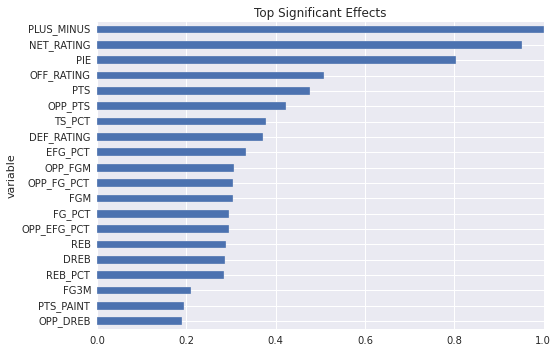

In [ ]:
plotvars = ['']

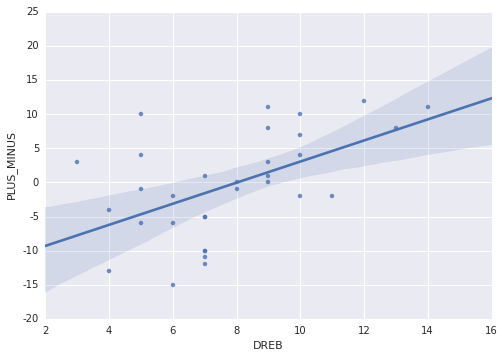

In [10]:
sns.regplot(y="PLUS_MINUS",x="DREB",data=df)

In [220]:
rsqrs

rsquared  abs_rsquared
variable                                   
TEAM_ID          1.110223e-16  1.110223e-16
TEAM_NAME        1.110223e-16  1.110223e-16
GP               1.110223e-16  1.110223e-16
W                1.177812e-01  1.177812e-01
L                1.177812e-01  1.177812e-01
W_PCT            1.177812e-01  1.177812e-01
MIN              1.110223e-16  1.110223e-16
FGM              2.496175e-01  2.496175e-01
FGA              1.379503e-02  1.379503e-02
FG_PCT           2.682815e-01  2.682815e-01
FG3M             1.310869e-01  1.310869e-01
FG3A             2.669143e-02  2.669143e-02
FG3_PCT          5.963499e-02  5.963499e-02
FTM              1.767872e-02  1.767872e-02
FTA              9.450828e-03  9.450828e-03
FT_PCT           1.075379e-01  1.075379e-01
OREB             2.323704e-02  2.323704e-02
DREB             3.699900e-01  3.699900e-01
REB              3.273463e-01  3.273463e-01
AST              1.062225e-01  1.062225e-01
TOV              2.159288e-02  2.159288e-02
STL              1.298806e-02  1.298806e-02
BLK              1.685641e-01  1.685641e-01
BLKA             5.452930e-02  5.452930e-02
PF               9.315220e-03  9.315220e-03
PFD              1.938937e-02  1.938937e-02
PTS              3.508515e-01  3.508515e-01
PLUS_MINUS       9.521028e-01  9.521028e-01
CFID             1.110223e-16  1.110223e-16
CFPARAMS         1.110223e-16  1.110223e-16
...                       ...           ...
PCT_AST_2PM      1.839135e-02  1.839135e-02
PCT_FGA_3PT      1.812976e-02  1.812976e-02
PCT_FGA_2PT      1.812976e-02  1.812976e-02
PCT_PTS_2PT_MR   1.747549e-02  1.747549e-02
PCT_PTS_FT       3.367523e-02  3.367523e-02
PCT_UAST_3PM     4.595818e-02  4.595818e-02
PCT_PTS_3PT      2.531771e-02  2.531771e-02
PCT_PTS_PAINT    4.103543e-02  4.103543e-02
PCT_PTS_OFF_TOV  6.753850e-02  6.753850e-02
PCT_UAST_2PM     1.542003e-02  1.542003e-02
OPP_BLKA         1.685641e-01  1.685641e-01
OPP_TOV          8.986232e-03  8.986232e-03
OPP_FTA          9.829591e-04  9.829591e-04
OPP_BLK          5.452930e-02  5.452930e-02
OPP_FG3_PCT      1.402545e-01  1.402545e-01
OPP_REB          6.225924e-02  6.225924e-02
OPP_FGM          3.966458e-01  3.966458e-01
OPP_PF           1.938937e-02  1.938937e-02
OPP_PFD          9.315220e-03  9.315220e-03
OPP_FG_PCT       4.186389e-01  4.186389e-01
OPP_FT_PCT       6.902672e-05  6.902672e-05
OPP_STL          5.339759e-06  5.339759e-06
OPP_FG3A         2.263071e-03  2.263071e-03
OPP_PTS          5.199713e-01  5.199713e-01
OPP_AST          2.187081e-01  2.187081e-01
OPP_FGA          5.100084e-04  5.100084e-04
OPP_OREB         1.553097e-02  1.553097e-02
OPP_DREB         1.477487e-01  1.477487e-01
OPP_FTM          1.055417e-04  1.055417e-04
OPP_FG3M         1.891725e-01  1.891725e-01

[99 rows x 2 columns]

# Functions

In [6]:
def get_model_var(_vars_of_interest,_target,_df,result):
    """Run linear model on targets, get back frame of results
    
    >>> pvals = get_model_var(vars_of_interest,target,df,"pvalue")
    """
    output = []
    for v in _vars_of_interest:
        formstring = _target + " ~ " + v
        #print formstring
        try:
            lm = smf.ols(formula=formstring,data=_df).fit()
            if result == "pvalue":
                output.append((v,lm.pvalues[1]))
            if result == "rsquared":
                output.append((v,lm.rsquared))
            if result == "coef":
                output.append((v,lm.params[1]))
        except:
            output.append((v,9999))
    output = pd.DataFrame(output,columns=['variable',result])
    output.set_index('variable',inplace=True)
    return(output)
        
    